# CIMSTONE SINIFLANDIRMA
* ELYSE_COANTE
* KAUNOS
* MAGNETITE
* MIRAD
* NARCISSUS_COANTE
* SNOW_FLAKE

olmak üzere altı tane çimstone taşı türü bulunmaktadır. Bu çalışmada Çimstone taşlarının sınıflandırılması amaçlanmıştır. 

---

## Drive'ın Mount Edilmesi

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


* Gerekli kütüphanelerin import edilmesi.
* Train, test ve validation veri kümelerinin çekilmesi ve gerekli ön işlemlerin yapılarak oluşturulması.
* Veri setinden birkaç örnek resim sunulması.

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.chdir("/content/drive/MyDrive/EklemeliStones")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from keras.applications import InceptionV3 , mobilenet,mobilenet_v2
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from keras.applications import EfficientNetB2,EfficientNetB3,EfficientNetB5
from keras.preprocessing.image import ImageDataGenerator
from keras import Model 
from keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D,BatchNormalization
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from keras.applications import resnet
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn import metrics

from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

import seaborn as sns
sns.set_style('darkgrid')

Found 2686 images belonging to 6 classes.
Found 337 images belonging to 6 classes.
Found 337 images belonging to 6 classes.


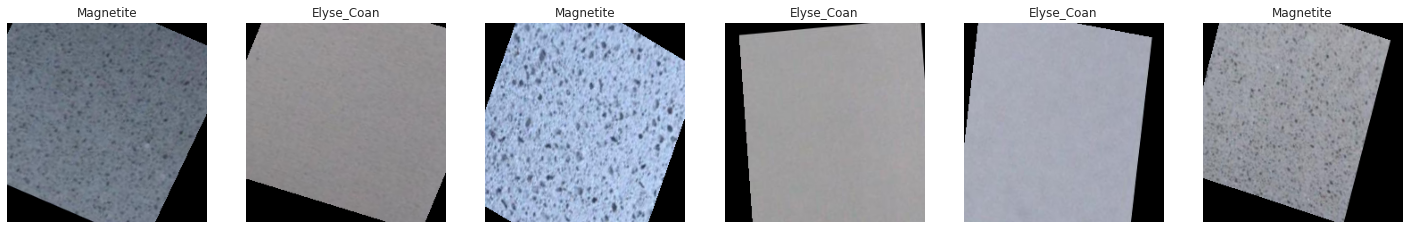

In [ ]:
EPOCHS = 10
train_data_gen = ImageDataGenerator(rotation_range=30,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='constant',
                                    cval=0,
                                    rescale=1./255)
valid_data_gen = ImageDataGenerator(rotation_range=35,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='constant',
                                    cval=0,
                                    rescale=1./255)

test_data_gen = ImageDataGenerator(rescale=1./255)

dataset_dir = '/content/drive/MyDrive/EklemeliStones/train/'
test_dr = '/content/drive/MyDrive/EklemeliStones/test_Cimstone/'
valid_dr = '/content/drive/MyDrive/EklemeliStones/valid_Cimstone'

Batch_size = 32
img_h = 224
img_w = 224
num_classes=6
classes = ['ELYSE_COANTE','KAUNOS', 'MAGNETITE','MIRAD', 'NARCISSUS_COANTE','SNOW_FLAKE']


# Training
SEED = 1234
tf.random.set_seed(SEED) 


train_gen = train_data_gen.flow_from_directory(dataset_dir,
                                               target_size=(224, 224),
                                               batch_size=Batch_size,
                                               classes=classes,
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=SEED)  # targets are directly converted into one-hot vectors

# Validation
valid_gen = valid_data_gen.flow_from_directory(valid_dr,
                                           target_size=(224, 224),
                                           batch_size=Batch_size, 
                                           classes=classes,
                                           class_mode='categorical',
                                           shuffle=False,
                                           seed=SEED)

test_gen = test_data_gen.flow_from_directory(test_dr,
                                             target_size=(224, 224),
                                             batch_size=1, 
                                             shuffle=False,
                                             seed=SEED,
                                             class_mode=None,
                                             )

class_names = np.array( ['ELYSE_COANTE','KAUNOS', 'MAGNETITE','MIRAD', 'NARCISSUS_COANTE','SNOW_FLAKE'], dtype='<U10')



def show_batch(image_batch, label_batch):
  plt.figure(figsize=(25,20))
  
  for n in range(0,6):
      ax = plt.subplot(1,6,n+1)
      plt.imshow(image_batch[n])
      plt.title(class_names[label_batch[n]==True][0].title())
      plt.axis('off')
      
image_batch, label_batch = next(train_gen)
show_batch(image_batch, label_batch)

In [ ]:
def cm_cr(test_gen, model):
    preds=model.predict(test_gen)    
    labels=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    pred_list=[ ] 
    true_list=[]
    for i, p in enumerate (preds):
        index=np.argmax(p)
        pred_list.append(classes[index])
        true_list.append(classes[labels[i]])
    y_pred=np.array(pred_list)
    y_true=np.array(true_list)
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)
    cm = confusion_matrix(y_true, y_pred )        
    length=len(classes)
    if length<8:
        fig_width=8
        fig_height=8
    else:
        fig_width= int(length * .5)
        fig_height= int(length * .5)
    plt.figure(figsize=(fig_width, fig_height))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
    plt.xticks(np.arange(length)+.5, classes, rotation= 90, fontsize=16)
    plt.yticks(np.arange(length)+.5, classes, rotation=0, fontsize=16)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

In [ ]:
def scoreGraph(history):
  print(history.history.keys())
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [ ]:
def roc_auc(test_gen,model):
  STEP_SIZE_TEST  = test_gen.n//test_gen.batch_size
  y_pred_keras = model.predict_generator(test_gen, steps=STEP_SIZE_TEST, verbose=1)
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_gen.classes, y_pred_keras[:,1], pos_label=1)
  auc_keras = auc(fpr_keras, tpr_keras)
  print("AUC : ",auc_keras)
  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  plt.show()

# ResNet50 MODELİ
* Modelin yüklenmesi yapılmaktadır. 
* Modelin oluşturulması.
* Modelin derlenmesi.
* ResNet Modeli ile veri kümesinin eğitilmesi.

In [ ]:
def RESNET50():
  # ALTTAKİ SATIRA weights='imagenet' EKLENEREK TRANSFER ÖĞRENME YAPILABİLİR. 
  # DİĞERLERİNE UYGULADIM. 
  resnet50_base = resnet.ResNet50(include_top=False, input_tensor=None, input_shape=(img_h, img_w,3))

  tf.keras.layers.Rescaling(1./255)
  output = resnet50_base.get_layer(index = -1).output  
  output = Flatten()(output)
  output = Dense(512,activation = "relu")(output)
  output = BatchNormalization()(output)
  output = Dropout(0.2)(output)
  output = Dense(512,activation = "relu")(output)
  output = BatchNormalization()(output)
  output = Dropout(0.2)(output)
  output = Dense(6, activation='softmax')(output)
  resnet50_model = Model(resnet50_base.input, output)
  for layer in resnet50_model.layers[:-7]:
      layer.trainable = False
  resnet50_model.summary()
  print(len(resnet50_model.layers))
  resnet50_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics =['accuracy'])

  callbacks = EarlyStopping(monitor='val_loss', patience=4, verbose=2, mode='auto')
  reduce_lr = ReduceLROnPlateau(patience=5, monitor='val_acc', factor=0.1, min_lr=0.0000001, mode='auto', verbose=2) #min_lr=0.0000001

  STEP_SIZE_TRAIN = train_gen.n//train_gen.batch_size
  STEP_SIZE_VALID = valid_gen.n//valid_gen.batch_size
  STEP_SIZE_TEST  = test_gen.n//test_gen.batch_size
  
  transfer_learning_history = resnet50_model.fit_generator(generator=train_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_gen,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=EPOCHS, callbacks = [callbacks]
                      )        
  
  resnet50_model.save("/content/drive/MyDrive/EklemeliStones/cimstone_resnet50.h5")  
  # VAROLAN EĞİTİLMİŞ BİR MODEL YÜKLENMEK İSTENİRSE
  #from keras.models import load_model
  #model_new = load_model("/content/drive/MyDrive/EklemeliStones/cimstone_resnet50.h5")
  #model_new.evaluate(valid_gen, steps=valid_gen.n//valid_gen.batch_size,verbose=1)
  #pred = model_new.predict(test_gen,steps=test_gen.n//valid_gen.batch_size,verbose=1)     
  # MEVCUT YUKARIDA EĞİTİLEN MODEL İLE DEVAM ETMEK İSTENİRSE
  resnet50_model.evaluate(valid_gen, steps=valid_gen.n//valid_gen.batch_size,verbose=1)
  pred = resnet50_model.predict(test_gen,steps=test_gen.n//valid_gen.batch_size,verbose=1)
  # YENİ EĞİTİLEN MODELİN HISTORYSİNE BAKARAK GRAFİK OLUŞTURULUR.
  scoreGraph(transfer_learning_history)
  cm_cr(test_gen, resnet50_model)
  roc_auc(test_gen, resnet50_model)
        

94765736/94765736 [==============================] - 6s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

<ipython-input-7-cb45e05ea25b>:30: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  transfer_learning_history = resnet50_model.fit_generator(generator=train_gen,


Epoch 1/10
83/83 [==============================] - 2138s 26s/step - loss: 1.9637 - accuracy: 0.3259 - val_loss: 7.9108 - val_accuracy: 0.1375
Epoch 2/10
83/83 [==============================] - 41s 493ms/step - loss: 1.5227 - accuracy: 0.4375 - val_loss: 6.7176 - val_accuracy: 0.2781
Epoch 3/10
83/83 [==============================] - 41s 496ms/step - loss: 1.3936 - accuracy: 0.4808 - val_loss: 2.1337 - val_accuracy: 0.3438
Epoch 4/10
83/83 [==============================] - 40s 482ms/step - loss: 1.2819 - accuracy: 0.5083 - val_loss: 7.6154 - val_accuracy: 0.2125
Epoch 5/10
83/83 [==============================] - 40s 487ms/step - loss: 1.2700 - accuracy: 0.5215 - val_loss: 5.0695 - val_accuracy: 0.2812
Epoch 6/10
83/83 [==============================] - 41s 498ms/step - loss: 1.2216 - accuracy: 0.5365 - val_loss: 2.4088 - val_accuracy: 0.3313
Epoch 7/10
83/83 [==============================] - 41s 491ms/step - loss: 1.1860 - accuracy: 0.5501 - val_loss: 1.7849 - val_accuracy: 0.4094

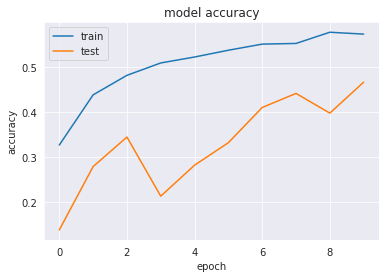

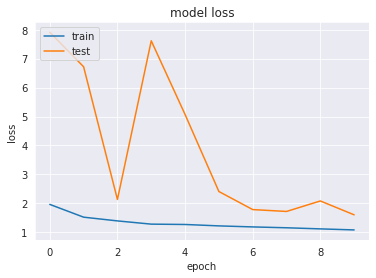

337/337 [==============================] - 277s 824ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
----------------------
                   precision    recall  f1-score   support

    ELYSE_COANTE       1.00      0.13      0.24        60
          KAUNOS       0.45      0.71      0.56        70
       MAGNETITE       0.52      0.93      0.67        75
           MIRAD       0.32      0.44      0.37        62
NARCISSUS_COANTE       0.00      0.00      0.00        34
      SNOW_FLAKE       0.00      0.00      0.00        36

        accuracy                           0.46       337
       macro avg       0.38      0.37      0.30       337
    weighted avg       0.45      0.46      0.37       337



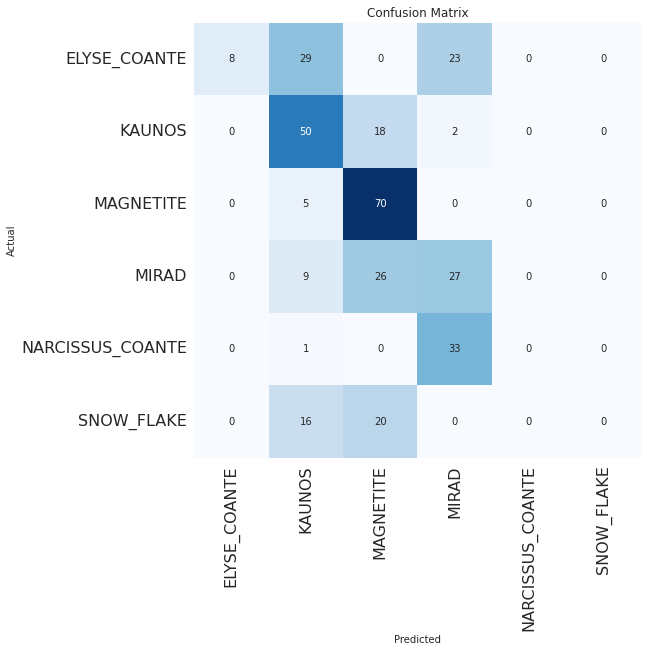

  8/337 [..............................] - ETA: 5s

<ipython-input-6-8b09217d3068>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred_keras = model.predict_generator(test_gen, steps=STEP_SIZE_TEST, verbose=1)


337/337 [==============================] - 5s 15ms/step
AUC :  0.8630283574103799


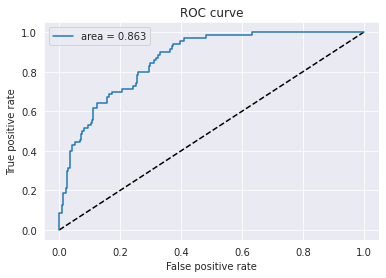

In [ ]:
RESNET50()

# VGG16 MODELİ
* Train, test ve validation veri kümelerinin çekilmesi ve gerekli ön işlemlerin yapılarak oluşturulması.
* VGG modelinin yüklenmesi ve modelin oluşturulması. 
* Modelin derlenip, veri kümesi üzerinde eğitilmesi.

In [ ]:
def VirtualGG16():
  vgg16_base = VGG16(include_top=False, input_tensor=None,weights='imagenet', input_shape=(img_h, img_w,3))

  output = vgg16_base.get_layer(index = -1).output  
  output = Flatten()(output)
  # let's add a fully-connected layer
  output = Dense(1024,activation = "relu")(output)
  output = BatchNormalization()(output)
  output = Dropout(0.2)(output)
  output = Dense(1024,activation = "relu")(output)
  output = BatchNormalization()(output)
  output = Dropout(0.2)(output)
  output = Dense(6, activation='softmax')(output)
  vgg16_model = Model(vgg16_base.input, output)
  for layer in vgg16_model.layers[:-7]:
      layer.trainable = False
  vgg16_model.summary()
  vgg16_model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics =['accuracy'])

  callbacks = EarlyStopping(monitor='val_loss', patience=4, verbose=2, mode='auto')
  reduce_lr = ReduceLROnPlateau(patience=5, monitor='val_acc', factor=0.1, min_lr=0.0000001, mode='auto', verbose=2) #min_lr=0.0000001

  STEP_SIZE_TRAIN = train_gen.n//train_gen.batch_size
  STEP_SIZE_VALID = valid_gen.n//valid_gen.batch_size
  STEP_SIZE_TEST  = test_gen.n//test_gen.batch_size


  history = vgg16_model.fit_generator(train_gen,
                                epochs=EPOCHS,
                                verbose=1,
                                validation_data=valid_gen,
                                callbacks = [callbacks]
                                )

  vgg16_model.save("/content/drive/MyDrive/EklemeliStones/cimstone_vgg16.h5")  
  # VAROLAN EĞİTİLMİŞ BİR MODEL YÜKLENMEK İSTENİRSE
  #from keras.models import load_model
  #model_new = load_model("/content/drive/MyDrive/EklemeliStones/cimstone_vgg16.h5")
  #model_new.evaluate(valid_gen, steps=valid_gen.n//valid_gen.batch_size,verbose=1)
  #pred = model_new.predict(test_gen,steps=test_gen.n//valid_gen.batch_size,verbose=1)     
  # MEVCUT YUKARIDA EĞİTİLEN MODEL İLE DEVAM ETMEK İSTENİRSE
  vgg16_model.evaluate(valid_gen, steps=valid_gen.n//valid_gen.batch_size,verbose=1)
  pred = vgg16_model.predict(test_gen,steps=test_gen.n//valid_gen.batch_size,verbose=1)
  # YENİ EĞİTİLEN MODELİN HISTORYSİNE BAKARAK GRAFİK OLUŞTURULUR.
  scoreGraph(history)
  cm_cr(test_gen, vgg16_model)
  roc_auc(test_gen, vgg16_model)

58889256/58889256 [==============================] - 4s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

<ipython-input-9-954ac79770ca>:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = vgg16_model.fit_generator(train_gen,


Epoch 1/10
84/84 [==============================] - 52s 542ms/step - loss: 1.2964 - accuracy: 0.6121 - val_loss: 2.4020 - val_accuracy: 0.5104
Epoch 2/10
84/84 [==============================] - 41s 491ms/step - loss: 0.8589 - accuracy: 0.7144 - val_loss: 2.0627 - val_accuracy: 0.5579
Epoch 3/10
84/84 [==============================] - 41s 488ms/step - loss: 0.6664 - accuracy: 0.7695 - val_loss: 1.7026 - val_accuracy: 0.6024
Epoch 4/10
84/84 [==============================] - 41s 483ms/step - loss: 0.6489 - accuracy: 0.7762 - val_loss: 1.2743 - val_accuracy: 0.6499
Epoch 5/10
84/84 [==============================] - 41s 488ms/step - loss: 0.5788 - accuracy: 0.8101 - val_loss: 1.4310 - val_accuracy: 0.6884
Epoch 6/10
84/84 [==============================] - 41s 484ms/step - loss: 0.5522 - accuracy: 0.8116 - val_loss: 1.0564 - val_accuracy: 0.6677
Epoch 7/10
84/84 [==============================] - 41s 488ms/step - loss: 0.5150 - accuracy: 0.8150 - val_loss: 1.4233 - val_accuracy: 0.6202

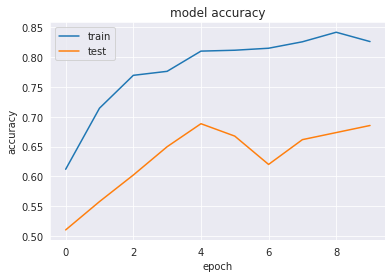

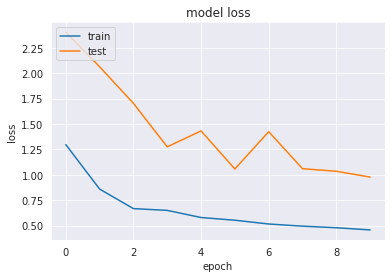

337/337 [==============================] - 4s 12ms/step
Classification Report:
----------------------
                   precision    recall  f1-score   support

    ELYSE_COANTE       0.97      0.48      0.64        60
          KAUNOS       0.79      0.90      0.84        70
       MAGNETITE       0.96      0.93      0.95        75
           MIRAD       0.93      0.68      0.79        62
NARCISSUS_COANTE       0.61      0.91      0.73        34
      SNOW_FLAKE       0.59      0.94      0.72        36

        accuracy                           0.80       337
       macro avg       0.81      0.81      0.78       337
    weighted avg       0.84      0.80      0.80       337



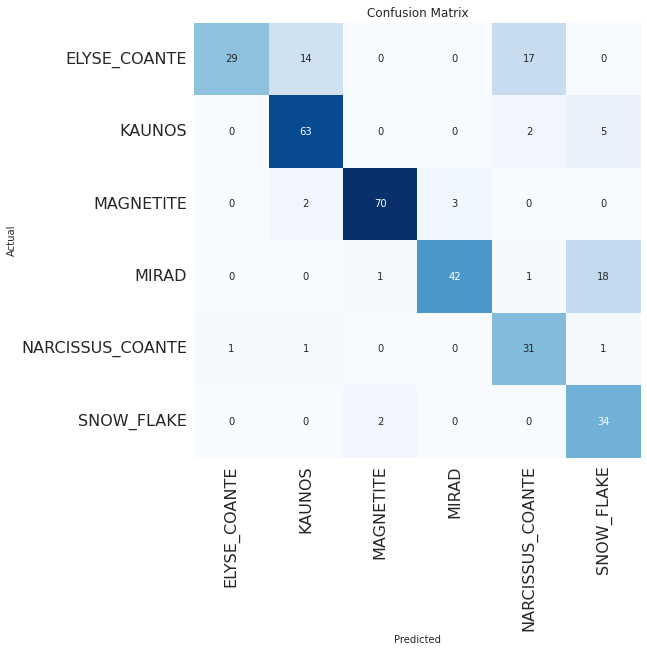

  6/337 [..............................] - ETA: 3s 

<ipython-input-6-8b09217d3068>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred_keras = model.predict_generator(test_gen, steps=STEP_SIZE_TEST, verbose=1)


337/337 [==============================] - 3s 10ms/step
AUC :  0.9840021401819155


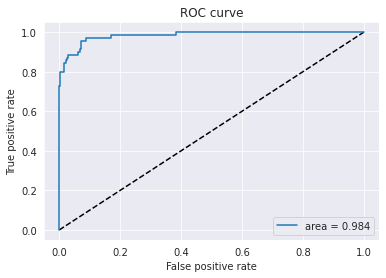

In [ ]:
VirtualGG16()

# INCEPTION MODELİ
* Modelin yüklenmesi ve oluşturulması.
* Modelin derlenmesi ve veri kümesi üzerinde modelin eğitilmesi.

In [ ]:
def INCEPTIONV3():

  inception_model = InceptionV3(include_top=False, input_tensor=None,weights='imagenet', input_shape=(img_h, img_w,3))

  output = inception_model.get_layer(index = -1).output  
  output = Flatten()(output)
  # let's add a fully-connected layer
  output = Dense(1024,activation = "relu")(output)
  output = BatchNormalization()(output)
  output = Dropout(0.2)(output)
  output = Dense(1024,activation = "relu")(output)
  output = BatchNormalization()(output)
  output = Dropout(0.2)(output)
  output = Dense(6, activation='softmax')(output)
  inception_model = Model(inception_model.input, output)
  for layer in inception_model.layers[:-7]:
      layer.trainable = False
  inception_model.summary()
  inception_model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics =['accuracy'])

  callbacks = EarlyStopping(monitor='val_loss', patience=4, verbose=2, mode='auto')
  reduce_lr = ReduceLROnPlateau(patience=5, monitor='val_acc', factor=0.1, min_lr=0.0000001, mode='auto', verbose=2) #min_lr=0.0000001

  STEP_SIZE_TRAIN = train_gen.n//train_gen.batch_size
  STEP_SIZE_VALID = valid_gen.n//valid_gen.batch_size
  STEP_SIZE_TEST  = test_gen.n//test_gen.batch_size

  history = inception_model.fit_generator(train_gen,
                                epochs=EPOCHS,
                                verbose=1,
                                validation_data=valid_gen,
                                callbacks = [callbacks]
                                )
  inception_model.save("/content/drive/MyDrive/EklemeliStones/cimstone_inception.h5")  
  # VAROLAN EĞİTİLMİŞ BİR MODEL YÜKLENMEK İSTENİRSE
  #from keras.models import load_model
  #model_new = load_model("/content/drive/MyDrive/EklemeliStones/cimstone_inception.h5")
  #model_new.evaluate(valid_gen, steps=valid_gen.n//valid_gen.batch_size,verbose=1)
  #pred = model_new.predict(test_gen,steps=test_gen.n//valid_gen.batch_size,verbose=1)     
  # MEVCUT YUKARIDA EĞİTİLEN MODEL İLE DEVAM ETMEK İSTENİRSE
  inception_model.evaluate(valid_gen, steps=valid_gen.n//valid_gen.batch_size,verbose=1)
  pred = inception_model.predict(test_gen,steps=test_gen.n//valid_gen.batch_size,verbose=1)
  # YENİ EĞİTİLEN MODELİN HISTORYSİNE BAKARAK GRAFİK OLUŞTURULUR.
  scoreGraph(history)
  cm_cr(test_gen, inception_model)
  roc_auc(test_gen, inception_model)
      

87910968/87910968 [==============================] - 5s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 rmalization)              

<ipython-input-11-556fa282c608>:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = inception_model.fit_generator(train_gen,


Epoch 1/10
84/84 [==============================] - 57s 579ms/step - loss: 1.1416 - accuracy: 0.6709 - val_loss: 1.9867 - val_accuracy: 0.6380
Epoch 2/10
84/84 [==============================] - 40s 476ms/step - loss: 0.7677 - accuracy: 0.7662 - val_loss: 1.2117 - val_accuracy: 0.7240
Epoch 3/10
84/84 [==============================] - 40s 479ms/step - loss: 0.6145 - accuracy: 0.7900 - val_loss: 1.0408 - val_accuracy: 0.7211
Epoch 4/10
84/84 [==============================] - 41s 484ms/step - loss: 0.5500 - accuracy: 0.8299 - val_loss: 0.9769 - val_accuracy: 0.6944
Epoch 5/10
84/84 [==============================] - 40s 478ms/step - loss: 0.5438 - accuracy: 0.8153 - val_loss: 0.7827 - val_accuracy: 0.7270
Epoch 6/10
84/84 [==============================] - 40s 480ms/step - loss: 0.4703 - accuracy: 0.8410 - val_loss: 1.0111 - val_accuracy: 0.7418
Epoch 7/10
84/84 [==============================] - 40s 476ms/step - loss: 0.4404 - accuracy: 0.8477 - val_loss: 0.9209 - val_accuracy: 0.7300

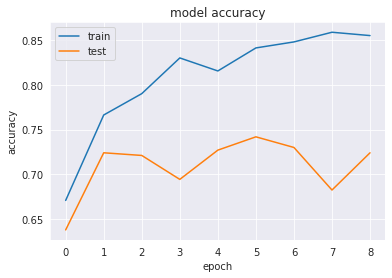

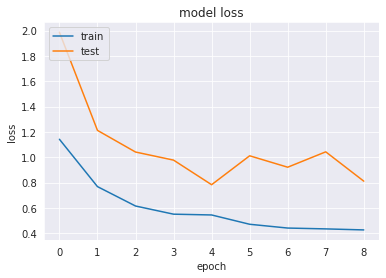

337/337 [==============================] - 6s 19ms/step
Classification Report:
----------------------
                   precision    recall  f1-score   support

    ELYSE_COANTE       0.86      0.95      0.90        60
          KAUNOS       0.89      0.93      0.91        70
       MAGNETITE       0.84      0.91      0.87        75
           MIRAD       0.90      0.92      0.91        62
NARCISSUS_COANTE       0.97      0.85      0.91        34
      SNOW_FLAKE       0.88      0.58      0.70        36

        accuracy                           0.88       337
       macro avg       0.89      0.86      0.87       337
    weighted avg       0.88      0.88      0.88       337



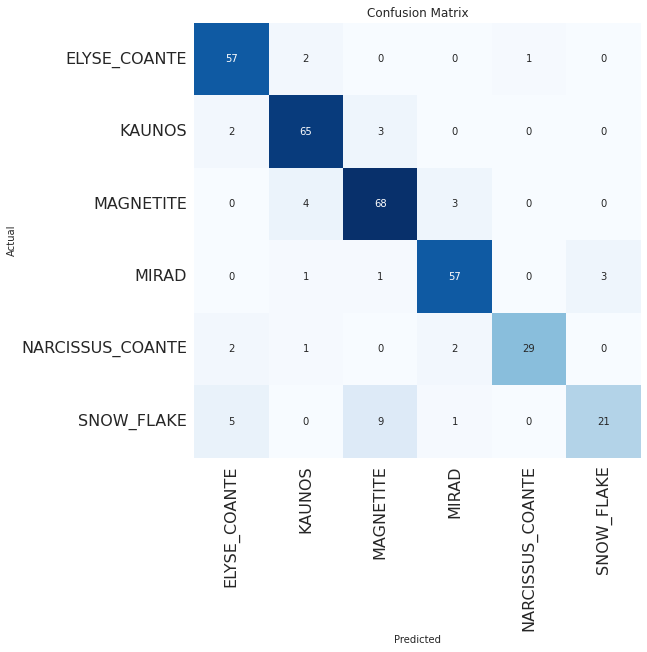

  3/337 [..............................] - ETA: 9s 

<ipython-input-6-8b09217d3068>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred_keras = model.predict_generator(test_gen, steps=STEP_SIZE_TEST, verbose=1)


337/337 [==============================] - 8s 23ms/step
AUC :  0.9840556447298021


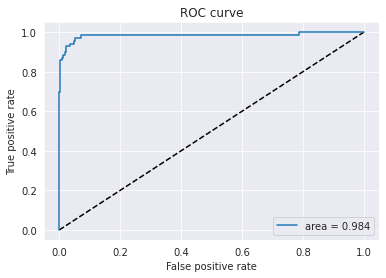

In [ ]:
INCEPTIONV3()

# EfficentNet MODELİ
* Modelin yüklenmesi ve oluşturulması.
* Modelin derlenmesi ve veri kümesi üzerinde eğitilmesi.

In [ ]:
def EFFICIENTNET():
# EfficientNet yüklemesi
  efficent_model=EfficientNetB3(include_top=False, input_tensor=None,weights='imagenet', input_shape=(img_h, img_w,3))

  output = efficent_model.get_layer(index = -1).output  
  output = Flatten()(output)
  # let's add a fully-connected layer
  output = Dense(1024,activation = "relu")(output)
  output = BatchNormalization()(output)
  output = Dropout(0.2)(output)
  output = Dense(1024,activation = "relu")(output)
  output = BatchNormalization()(output)
  output = Dropout(0.2)(output)
  output = Dense(6, activation='softmax')(output)
  efficent_model = Model(efficent_model.input, output)
  for layer in efficent_model.layers[:-7]:
      layer.trainable = False
  efficent_model.summary()
  efficent_model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics =['accuracy'])

  callbacks = EarlyStopping(monitor='val_loss', patience=4, verbose=2, mode='auto')
  reduce_lr = ReduceLROnPlateau(patience=5, monitor='val_acc', factor=0.1, min_lr=0.0000001, mode='auto', verbose=2) #min_lr=0.0000001

  STEP_SIZE_TRAIN = train_gen.n//train_gen.batch_size
  STEP_SIZE_VALID = valid_gen.n//valid_gen.batch_size
  STEP_SIZE_TEST  = test_gen.n//test_gen.batch_size


  callbacks = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')
  reduce_lr = ReduceLROnPlateau(patience=5, monitor='val_acc', factor=0.1, min_lr=0.0000001, mode='auto', verbose=1)

  history = efficent_model.fit_generator(train_gen,
                                epochs=EPOCHS,
                                verbose=1,
                                validation_data=valid_gen,
                                callbacks = [callbacks]
                                )

  efficent_model.save("/content/drive/MyDrive/EklemeliStones/cimstone_efficent.h5")  
  # VAROLAN EĞİTİLMİŞ BİR MODEL YÜKLENMEK İSTENİRSE
  #from keras.models import load_model
  #model_new = load_model("/content/drive/MyDrive/EklemeliStones/cimstone_efficent.h5")
  #model_new.evaluate(valid_gen, steps=valid_gen.n//valid_gen.batch_size,verbose=1)
  #pred = model_new.predict(test_gen,steps=test_gen.n//valid_gen.batch_size,verbose=1)     
  # MEVCUT YUKARIDA EĞİTİLEN MODEL İLE DEVAM ETMEK İSTENİRSE
  efficent_model.evaluate(valid_gen, steps=valid_gen.n//valid_gen.batch_size,verbose=1)
  pred = efficent_model.predict(test_gen,steps=test_gen.n//valid_gen.batch_size,verbose=1)
  # YENİ EĞİTİLEN MODELİN HISTORYSİNE BAKARAK GRAFİK OLUŞTURULUR.
  scoreGraph(history)
  cm_cr(test_gen, efficent_model)
  roc_auc(test_gen, efficent_model)
      

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.11.0


In [ ]:
# TF_Version hatası kronik bir keras sorunu. Çözüm için :
# https://github.com/keras-team/keras/issues/17199
"""
Got the exact same issue with TF 2.10 and TF 2.11 (tried to save model in saved_model format and in H5 format, neither worked).
Downgrading to TF2.9 helped for now but it would be really nice to be able to use TF more recent versions' features
"""
# YÜKLENDİKTEN SONRA RESTART RUNTIME YAPILMALI SADECE EFFICIENT NET ÇALIŞTIRILMALI !!!
!pip install tensorflow==2.9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 101.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 KB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 71.8 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.1.21
    Uninstalling flatbuffers-23.1.21:
      Successfully uninstalled flatbuffers-23.1.21
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully 

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                            

<ipython-input-5-0992702cb6dc>:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = efficent_model.fit_generator(train_gen,


Epoch 1/10
84/84 [==============================] - 61s 560ms/step - loss: 2.1022 - accuracy: 0.2885 - val_loss: 20.0019 - val_accuracy: 0.1573
Epoch 2/10
84/84 [==============================] - 44s 526ms/step - loss: 1.8198 - accuracy: 0.3131 - val_loss: 16.4220 - val_accuracy: 0.1780
Epoch 3/10
84/84 [==============================] - 47s 556ms/step - loss: 1.6998 - accuracy: 0.3358 - val_loss: 17.1105 - val_accuracy: 0.2077
Epoch 4/10
84/84 [==============================] - 43s 513ms/step - loss: 1.6804 - accuracy: 0.3529 - val_loss: 7.1847 - val_accuracy: 0.1068
Epoch 5/10
84/84 [==============================] - 43s 514ms/step - loss: 1.6325 - accuracy: 0.3548 - val_loss: 21.8626 - val_accuracy: 0.1780
Epoch 6/10
84/84 [==============================] - 44s 525ms/step - loss: 1.6151 - accuracy: 0.3686 - val_loss: 12.2812 - val_accuracy: 0.2226
Epoch 7/10
84/84 [==============================] - 46s 548ms/step - loss: 1.6083 - accuracy: 0.3578 - val_loss: 4.7838 - val_accuracy: 0

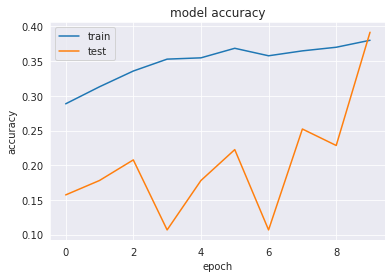

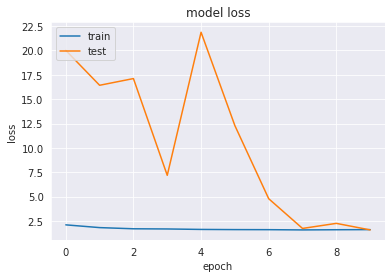

337/337 [==============================] - 10s 29ms/step
Classification Report:
----------------------
                   precision    recall  f1-score   support

    ELYSE_COANTE       0.29      1.00      0.44        60
          KAUNOS       0.00      0.00      0.00        70
       MAGNETITE       1.00      0.57      0.73        75
           MIRAD       0.15      0.19      0.17        62
NARCISSUS_COANTE       0.00      0.00      0.00        34
      SNOW_FLAKE       0.00      0.00      0.00        36

        accuracy                           0.34       337
       macro avg       0.24      0.29      0.22       337
    weighted avg       0.30      0.34      0.27       337



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


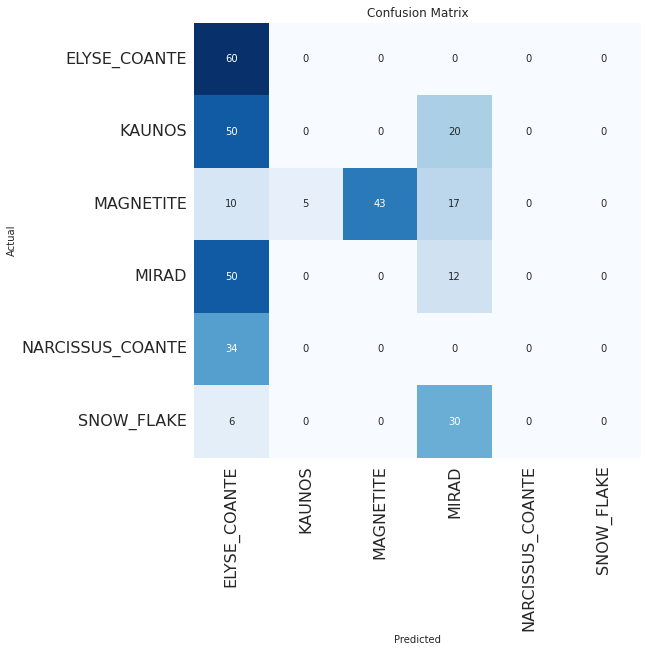

  4/337 [..............................] - ETA: 7s 

<ipython-input-9-8b09217d3068>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred_keras = model.predict_generator(test_gen, steps=STEP_SIZE_TEST, verbose=1)


337/337 [==============================] - 7s 22ms/step
AUC :  0.5473515248796148


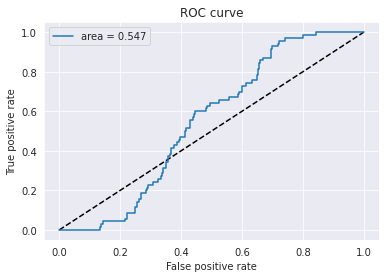

In [ ]:
EFFICIENTNET()